In [243]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt 
import numpy as np

from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
## Library 1

from sktime.distances.elastic_cython import dtw_distance
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

import seaborn as sns
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
from collections import Counter

## Library 2
# from dtw import *

import sqlite3




### Importing the industry wise stocks for companies in the timezone where the new tariffs were introduced.
#### 1. The DTW algorithm helps to calculate the patterns between 2 time series. The temporal nature of data is undertaken in the comparison as compared to standard Euclidean methods. 
#### 2. Based on the number of 'Sharp peaks', 'Steady growth', 'Constant Trend', 'Steady Drops' and 'Sharp Drops' in the stock prices, we can estimate the impact of tariffs on the market setiment and company.





In [222]:
companies = ['TSLA']

yahoo_financials = YahooFinancials(companies)

data = yahoo_financials.get_historical_price_data(start_date='2019-01-01',
                                                  end_date='2019-12-31',
                                                  time_interval='daily')

prices_df = pd.DataFrame({
    a: {x['formatted_date']: x['adjclose'] for x in data[a]['prices']} for a in companies
})

prices_df


,TSLA
2019-01-02,62.023998
2019-01-03,60.071999
2019-01-04,63.537998
2019-01-07,66.991997
2019-01-08,67.070000
...,...
2019-12-23,83.844002
2019-12-24,85.050003
2019-12-26,86.188004
2019-12-27,86.075996


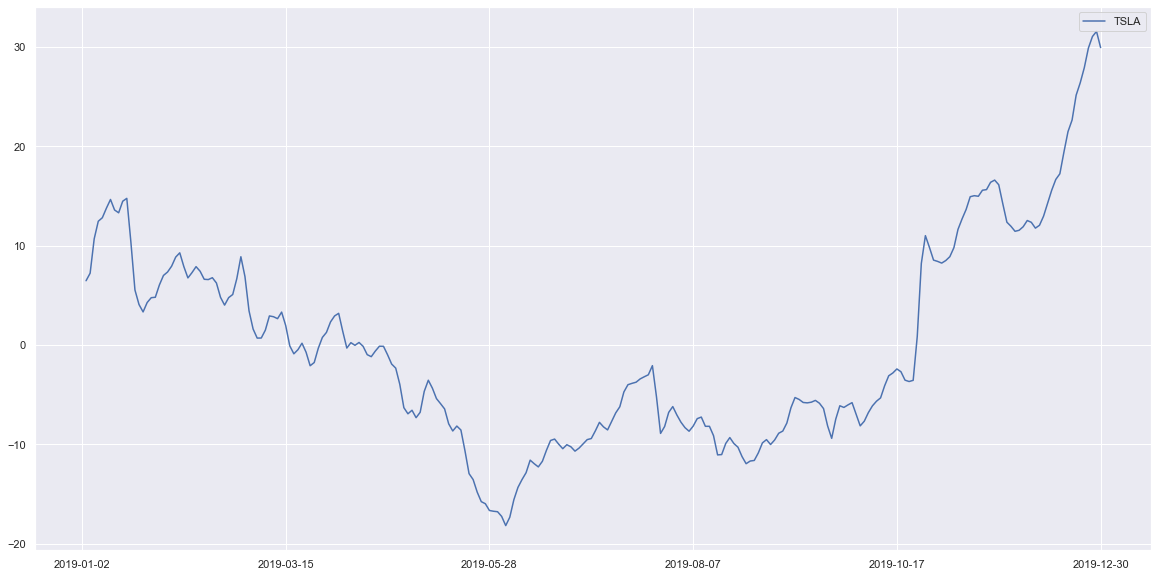

In [232]:
fig, ax = plt.subplots(figsize=(20,10))
prices_df.plot(ax=ax)

#### We Standartize and smooth out the ts for better estimations of similarity with DTW

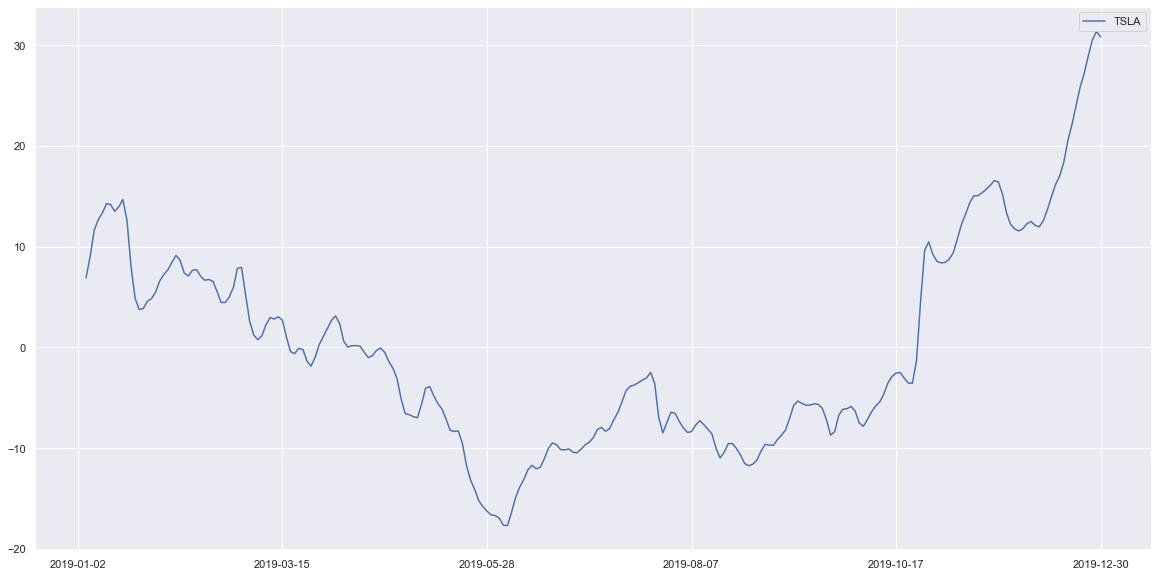

In [233]:
fig, ax = plt.subplots(figsize=(20,10))

cols = list(prices_df.columns)
lowess = sm.nonparametric.lowess

for col in cols:
    prices_df[col] = (prices_df[col]) - np.mean((prices_df[col]))
    prices_df[col] = prices_df[col].rolling(window=2).mean()
    
    
prices_df.plot(ax=ax)

### Data Preparation 
1. Splitting the TS in 40 chunks which are iteratively compared with each other for DTW score
2. The dictionary stores the indices of each TS 

In [234]:
# prices_dict = prices_df.to_dict('series')
# prices_df = np.array_split(prices_df, 10)
prices_df.dropna(inplace=True)

chunk_size = int(prices_df.shape[0] / 40)
i = 0

og_prices_dict = {}

for start in range(0, prices_df.shape[0], chunk_size):
    df_subset = prices_df.iloc[start:start + chunk_size]
    df_subset = (df_subset) - np.mean((df_subset))

    df_subset.columns = ['TSLA'+str(i)]
    new_prices_dict = df_subset.to_dict('series')
    og_prices_dict.update(new_prices_dict)
    i = i + 1
print(og_prices_dict) 

{'TSLA0': 2019-01-04   -4.402585
2019-01-07   -2.294085
2019-01-08    0.318915
2019-01-09    1.380416
2019-01-10    2.039918
2019-01-11    2.957420
Name: TSLA0, dtype: float64, 'TSLA1': 2019-01-14    1.351085
2019-01-15    0.681083
2019-01-16    1.122083
2019-01-17    1.848583
2019-01-18   -0.196918
2019-01-22   -4.805917
Name: TSLA1, dtype: float64, 'TSLA2': 2019-01-23    0.299083
2019-01-24   -0.804917
2019-01-25   -0.702917
2019-01-28    0.013083
2019-01-29    0.277584
2019-01-30    0.918084
Name: TSLA2, dtype: float64, 'TSLA3': 2019-01-31   -1.372499
2019-02-01   -0.722499
2019-02-04   -0.256999
2019-02-05    0.493499
2019-02-06    1.166999
2019-02-07    0.691499
Name: TSLA3, dtype: float64, 'TSLA4': 2019-02-08    0.123500
2019-02-11   -0.181000
2019-02-12    0.386000
2019-02-13    0.453000
2019-02-14   -0.182500
2019-02-15   -0.598999
Name: TSLA4, dtype: float64, 'TSLA5': 2019-02-19    1.274000
2019-02-20    1.101499
2019-02-21    0.115000
2019-02-22   -0.998000
2019-02-25   -1.01

### Model Fitting
#### The DTW funtions gives the minimum distance similarity between the lagged and current value of the time series with other time series. 
#### In this case the time series is split in 40 parts and each part is compared with other to form a DTW matrix which will be used to fit a hierarchical clustering model


In [235]:
distanceMatrix = np.empty((len(og_prices_dict), len(og_prices_dict),))
distanceMatrix[:] = np.nan

distanceMatrixDictionary = {}

for index1, (filter1, trajectory1) in enumerate(og_prices_dict.items()):
    
     for index2, (filter2, trajectory2) in enumerate(og_prices_dict.items()):
            
                unionFilter = str(filter1) + str(filter2)

                trajectory1 = np.asarray(trajectory1)
                trajectory2 = np.asarray(trajectory2)
                trajectory1 = trajectory1.reshape((-1, 1))
                trajectory2 = trajectory2.reshape((-1, 1))
                metric = dtw_distance(trajectory1, trajectory2)
                distanceMatrix[index1][index2] = metric
                distanceMatrixDictionary[unionFilter] = metric

D:\Program_Files\Anaconda\lib\site-packages\scipy\cluster\hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


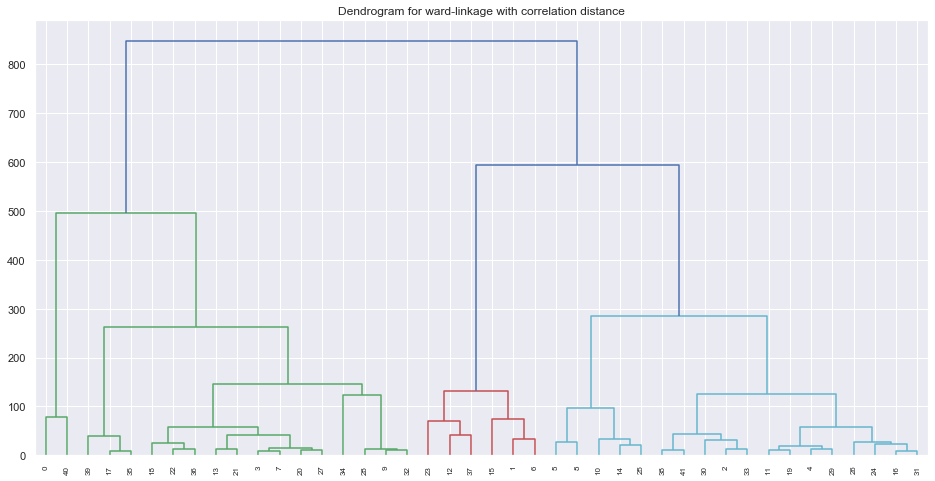

In [236]:
def hierarchical_clustering(distanceMatrix, method='ward'):
    if method == 'complete':
        Z = complete(distanceMatrix)
    if method == 'single':
        Z = single(distanceMatrix)
    if method == 'average':
        Z = average(distanceMatrix)
    if method == 'ward':
        Z = ward(distanceMatrix)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

linkage_matrix = hierarchical_clustering(distanceMatrix)

#### Add the cluster quality metrics for unsupervised learning 
    1. We will be looking at Inner cluster variance vs inter cluster variance ()
    2. Cluster size and Cluster distance ratio
    3. Distance of each observation in the cluster with other neighbouring cluster

Text(0.5, 1.0, 'calinski_harabasz_score')

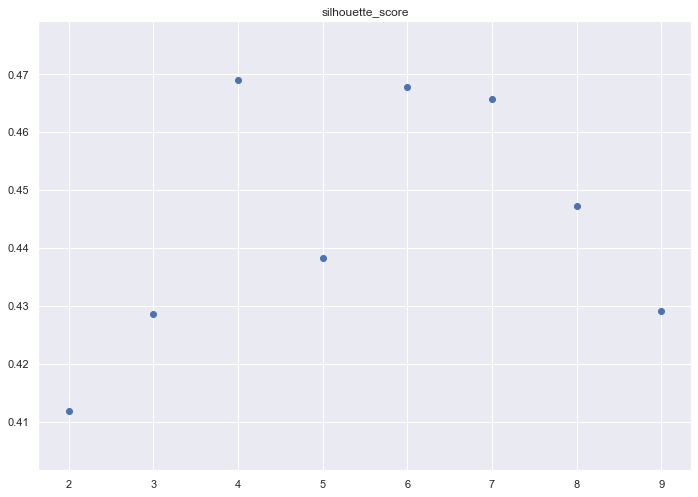

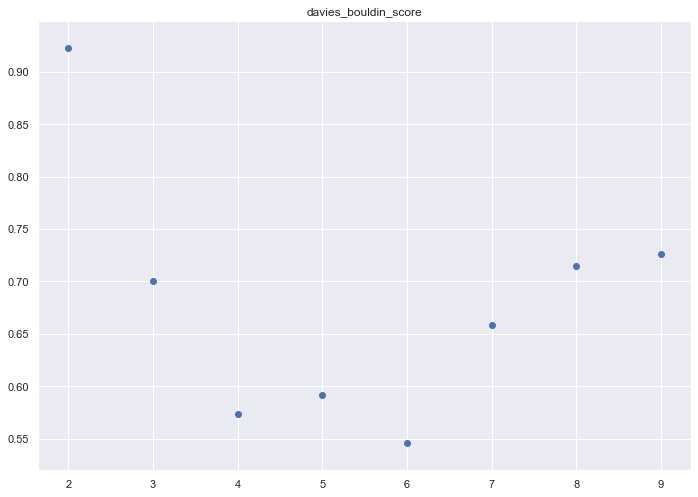

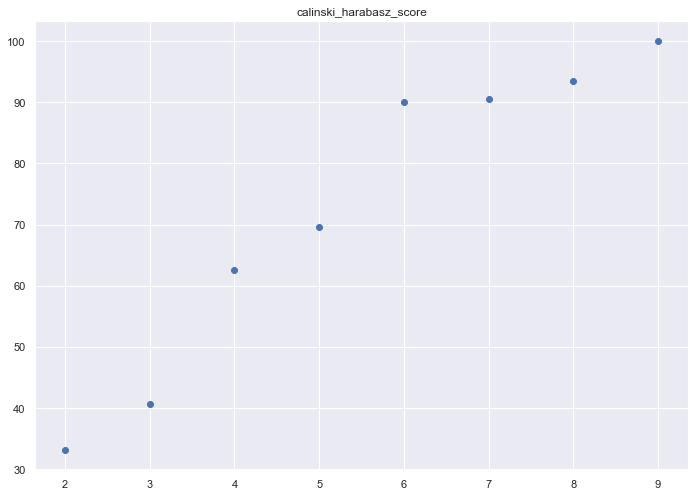

In [237]:
# distmatrix1 = scipy.spatial.distance.squareform(linkage_matrix + linkage_matrix.T)
# ddgm = scipy.cluster.hierarchy.linkage(distmatrix1, method="average")
# nodes = scipy.cluster.hierarchy.fcluster(ddgm, 4, criterion="maxclust")
fig,ax1 = plt.subplots()
fig,ax2 = plt.subplots()
fig,ax3 = plt.subplots()

scores1 = []
scores2 = []
scores3 = []
xax = []
for i in range(2,10):
    cluster_labels = fcluster(linkage_matrix, i, criterion='maxclust')
    score1 = metrics.silhouette_score(distanceMatrix + distanceMatrix.T , cluster_labels, metric='euclidean')
    score2 = metrics.davies_bouldin_score(distanceMatrix, cluster_labels)
    score3 = metrics.calinski_harabasz_score(distanceMatrix, cluster_labels)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)
    xax.append(i)
    
ax1.scatter(xax,scores1)
ax1.set_title('silhouette_score')
ax2.scatter(xax,scores2)
ax2.set_title('davies_bouldin_score')
ax3.scatter(xax,scores3)
ax3.set_title('calinski_harabasz_score')


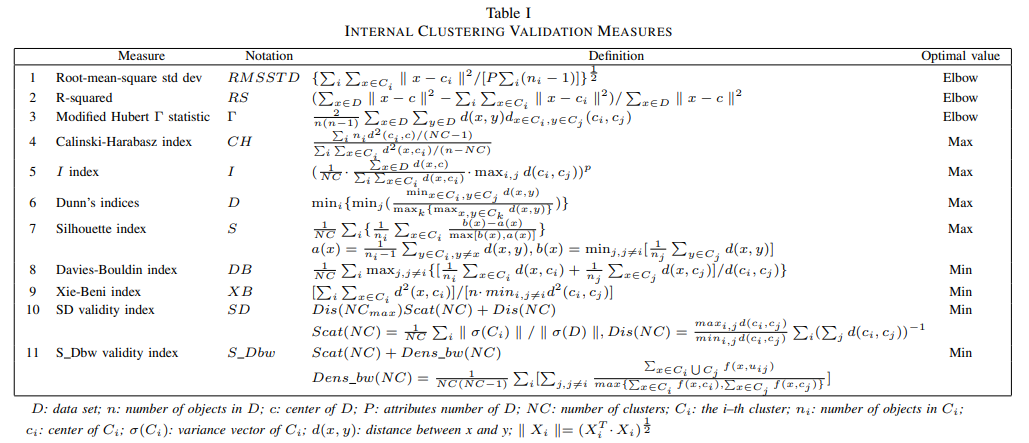

#### Based on the metrics we have used, cluster size 6 seems the perfect selection based on the estimates 

In [294]:
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
f = np.expand_dims(distanceMatrix, 1)

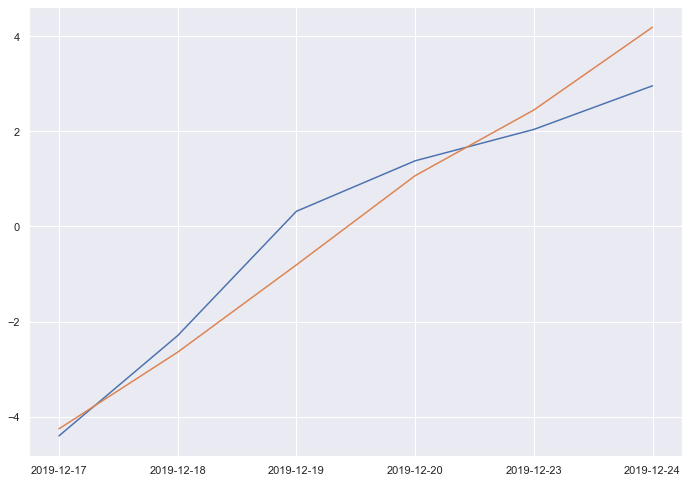

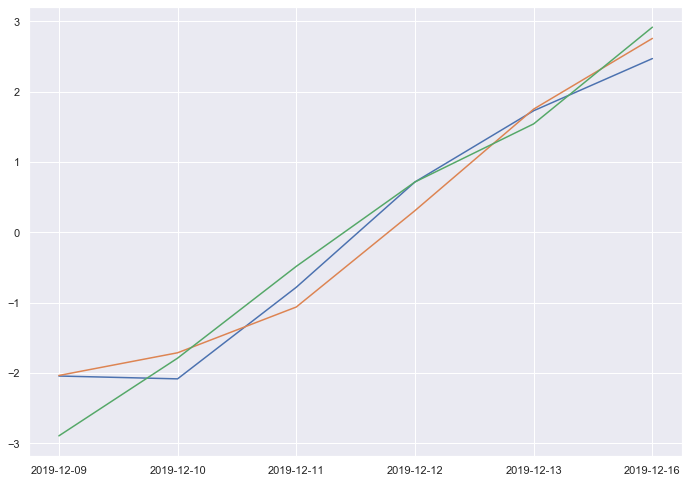

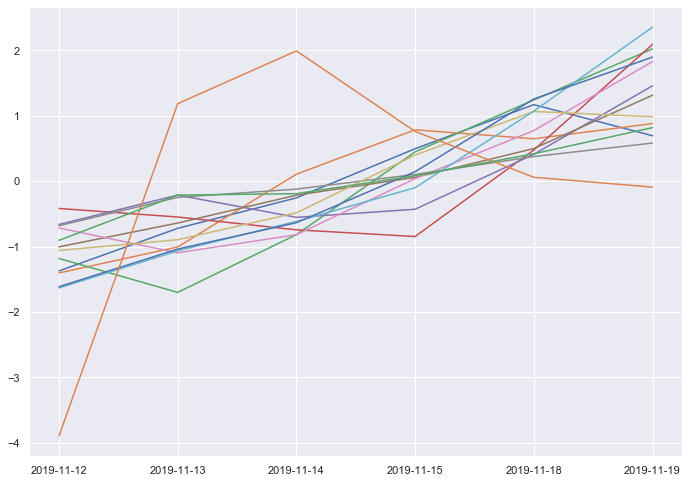

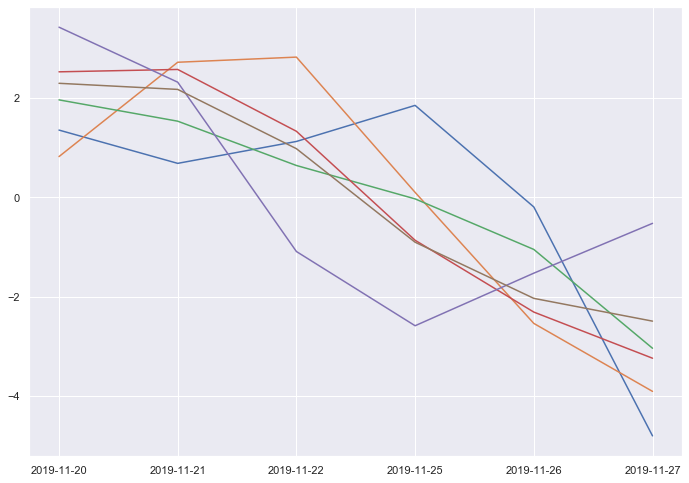

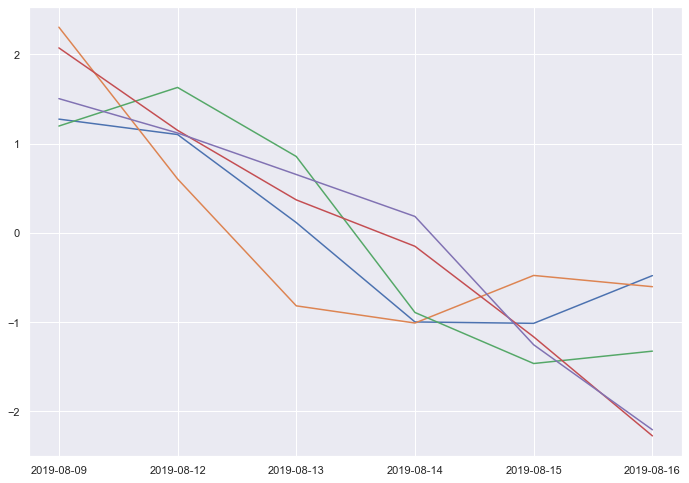

In [296]:
newdf = pd.DataFrame.from_dict(og_prices_dict)
newdf.reset_index(inplace=True)
mapping = {}
 
for index1, (filter1, trajectory1) in enumerate(og_prices_dict.items()): 
    mapping[filter1] = cluster_labels[index1]


for j in range(1,6):
    keys = [k for k,v in mapping.items() if v == j]    
    
    fig1, ax1 = plt.subplots(1,1)
 
    for i in keys:
        og_prices_dict[i].plot()

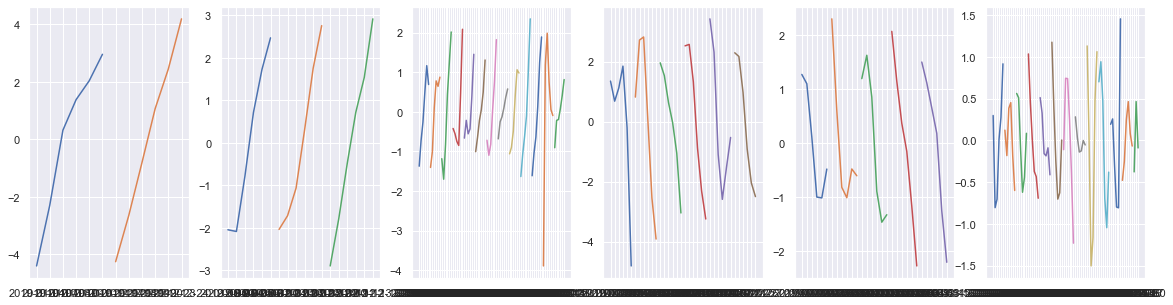

In [297]:
fig, ax1 = plt.subplots(1, int(len(np.unique(cluster_labels))),figsize=(20, 5))
z = 0

for row in ax1:
    keys = [k for k,v in mapping.items() if v == z+1]    
    z = z+1
    for i in keys:
        row.plot(og_prices_dict[i])

In [298]:


pred_df = pd.DataFrame(og_prices_dict)

# og_prices_dict[mapping['TSLA0']]

prices_df_op = prices_df.copy()
prices_df_op['Cluster'] = 0

for k, v in mapping.items():
    
    filt = (prices_df_op.index >= og_prices_dict[k].index.min()) & (prices_df_op.index <= og_prices_dict[k].index.max())
    prices_df_op.loc[(filt),'Cluster'] = v



prices_df_op.reset_index(inplace=True)
price_grouped = prices_df_op.groupby('Cluster')
prices_df_op['index'] = pd.to_datetime(prices_df_op['index'])

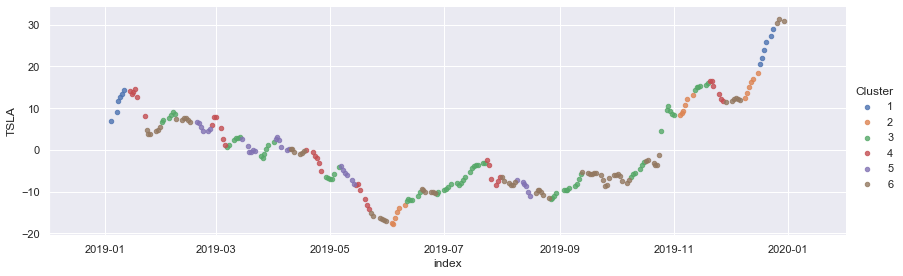

In [299]:
sns.lmplot('index', 'TSLA', data=prices_df_op, hue='Cluster', fit_reg=False, scatter_kws={"s": 20},height=4, aspect=3)

#### We can see that the clusters are highlighting the similarity in the trend line through each cluster
    1. Cluster 1 and 2 - Sharp Increase
    2. Cluster 3 - Steady Increase (Convex)
    3. Cluster 4 - Sudden Drop
    4. Cluster 5 - Steady Drop
    5. Cluster 6 - Steady Concave / Convex trends

#### Understanding the date of tarrifs to see how clusters are interpreting the stock returns  

In [300]:
SP500Con = sqlite3.connect("Dates.db")
cursor = SP500Con.cursor()
cursor.execute("""SELECT * FROM 'Dates'""")
ViewData = cursor.fetchall()
Date_pd = pd.DataFrame(ViewData)
Date_pd = Date_pd[Date_pd[2] < 0]
Date_pd.iloc[:,1] = pd.to_datetime(Date_pd.iloc[:,1])
Date_pd

,0,1,2
0,0,2019-02-24,-0.498621
2,2,2019-03-16,-2.441303
4,4,2019-04-05,-2.699955
5,5,2019-04-15,-0.145830
7,7,2019-05-05,-1.350696
8,8,2019-05-15,-0.527573
12,12,2019-06-24,-0.000615
14,14,2019-07-14,-0.184949
15,15,2019-07-24,-0.206536
19,19,2019-09-02,-0.228784


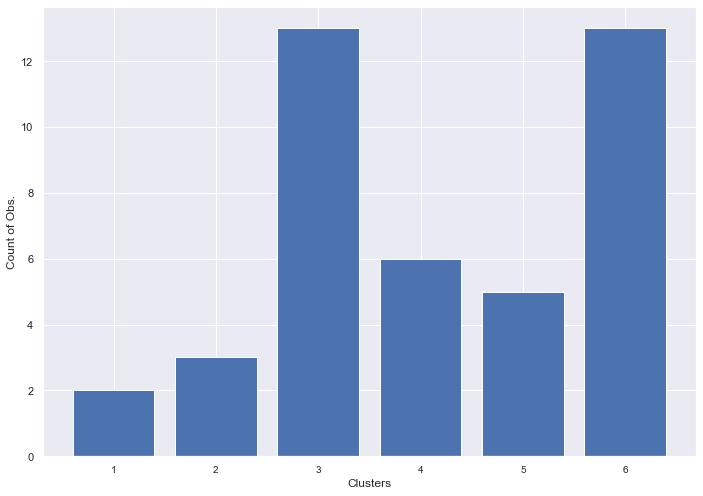

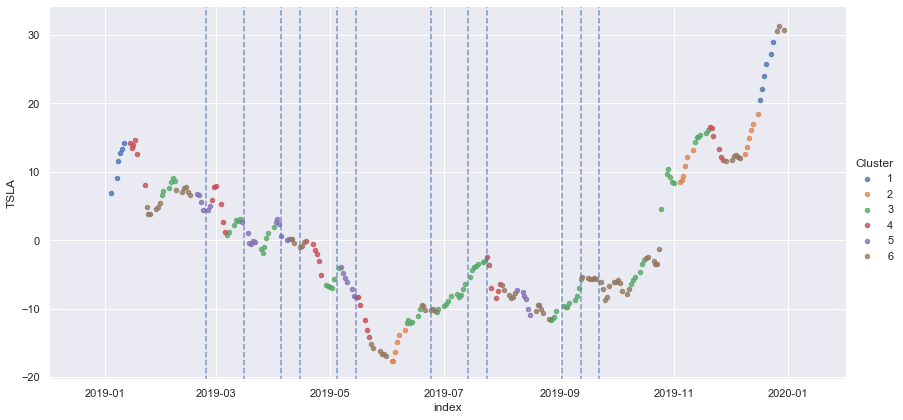

In [301]:
res = Counter(mapping.values())
keys = res.keys()
values = res.values()
plt.bar(keys, values,align='center')
plt.xticks(fontsize=10)
plt.xlabel('Clusters')
plt.ylabel('Count of Obs.')

sns.lmplot('index', 'TSLA', data=prices_df_op, hue='Cluster', fit_reg=False, scatter_kws={"s": 20},height=6, aspect=2)
for i in Date_pd.iloc[:,1]:
    plt.axvline(i,-5,5,alpha=0.7,linestyle='--',rasterized=True,solid_joinstyle='miter',animated =True)



### The verdict given by the model is the count of clusters for each trend
1. Clusters 1,2,3 are increasing trends with 18 observations
2. Clusters 4,5 are decreasing trends with 11 Observations
3. Cluster 6 is concave / convex trends with 13 observations

### Understanding the trend around the Tarrif Dates
1. We can see that for March, April and May Tarrifs the cluster 4 and 5 directly underlines the adverse tarrif effect on the stock return
2. For July, and August Tarrifs we see Cluster 3 showing the positive impact followed by cluster 4 showing the sharp decline
3. For September and October tarrifs the impact was much more steady highlighted by cluster 6

#### We can use the model to analyse the returns for the stock and impact of external factors for better and quick estimation of trends

In [ ]:

### dtaidistance Library

In [293]:
# distance = dtw.distance(prices_df['TSLA'], prices_df['MSFT'], psi=1)

# print(distance)
# path = dtw.warping_path(prices_df['TSLA'], prices_df['MSFT'])
# dtwvis.plot_warping(prices_df['TSLA'], prices_df['MSFT'], path)

# d, paths = dtw.warping_paths(prices_df['TSLA'], prices_df['MSFT'], window=50, psi=4)
# best_path = dtw.best_path(paths)
# dtwvis.plot_warpingpaths(prices_df['TSLA'], prices_df['MSFT'], paths, best_path)